# Script to add HISCLASS classifications to C-CLAMP
This script has to be available within the same folder as ...
1) `author_clean_final.txt`
2) `Release_HSN_HISCO_2013_01a.csv` (Zijdeman 2016)

In [2]:
# Import the necessary packages
import pandas as pd
import numpy as np
import re
from itertools import chain

## Step 1: Extract all occupations in the metadata file

In [4]:
# Read the metadata file
metadata_df = pd.read_csv("author_clean_final.txt", sep="\t", encoding="utf-8")
metadata_df = metadata_df.fillna('')
metadata_df.head(10)

,Author,Link,identifier,givenName,familyName,alternateNames,birthDate,birthPlace,birthCountry,deathDate,deathPlace,deathCountry,gender,occupation,period,language,category,organisation
0,Jan Engelman,https://www.dbnl.org/auteurs/auteur.php?id=eng...,enge016,Johannes Aloysius Antonius,Engelman,Jan Engelman,1900-06-07,Utrecht,Nederland,1972-03-20,Amsterdam,Nederland,male,redacteur/journalist/vertaler,Twintigste Eeuw,nl,secundair/nonfictie,
1,Willem Maas,https://www.dbnl.org/auteurs/auteur.php?id=maa...,maas024,Willem Arnoldus,Maas,Willem Maas,1897-04-28,Utrecht,Nederland,1950-05-06,Utrecht,Nederland,male,illustrator/tekenaar/beeldend kunstenaar,Twintigste Eeuw,,,
2,Joep Nicolas,https://www.dbnl.org/auteurs/auteur.php?id=nic...,nico008,Josephus Antonius Hubertus Franciscus,Nicolas,Joep Nicolas,1897-10-06,Roermond,Nederland,1972-07-25,Steyl,Nederland,male,schilder/ambachtsman,Twintigste Eeuw,,nonfictie,
3,Albert Helman,https://www.dbnl.org/auteurs/auteur.php?id=hel...,helm003,Albert,Helman,Albert Helman/Beckmesser/Brandaris/Floris Kapt...,1903-11-07,Paramaribo,Suriname,1996-07-10,Amsterdam,Nederland,male,musicus/journalist/politicus/redacteur/staatsm...,Twintigste Eeuw,nl,jeugdliteratuur/nonfictie/suriname/buitenland,
4,Willem Nieuwenhuis,https://www.dbnl.org/auteurs/auteur.php?id=nie...,nieu047,Willem,Nieuwenhuis,Willem Nieuwenhuis,1886-xx-xx,,,1935-xx-xx,,,male,,Twintigste Eeuw,nl,,
5,Karel van den Oever,https://www.dbnl.org/auteurs/auteur.php?id=oev...,oeve003,Karel,van den Oever,Karel van den Oever,1879-11-19,Antwerpen,België (Vlaanderen),1926-10-06,Antwerpen,België (Vlaanderen),male,arbeider/werkman,Twintigste Eeuw,nl,secundair/jeugdliteratuur,
6,Wies Moens,https://www.dbnl.org/auteurs/auteur.php?id=moe...,moen007,Aloys Caesar Antoon,Moens,Wies Moens,1898-01-28,Sint-Gillis-Bij-Dendermonde,België (Vlaanderen),1982-02-05,Geleen,Nederland,male,,Twintigste Eeuw,nl,secundair,
7,Eduard A. Serrarens,https://www.dbnl.org/auteurs/auteur.php?id=ser...,serr010,Eduard A.,Serrarens,Eduard A. Serrarens,1895-12-27,Maastricht,Nederland,1955-11-25,Roermond,Nederland,male,leraar/docent/hoogleraar,Twintigste Eeuw,nl,secundair,
8,Henk Kuitenbrouwer,https://www.dbnl.org/auteurs/auteur.php?id=kui...,kuit001,Carel Hendrik Gerhardus Maria,Kuitenbrouwer,Henk Kuitenbrouwer,1903-11-20,Utrecht,Nederland,1974-08-03,Utrecht,Nederland,male,onderwijzer (basisschool)/redacteur/journalist,Twintigste Eeuw,,jeugdliteratuur,
9,Jan Bruna,https://www.dbnl.org/auteurs/auteur.php?id=bru...,brun020,Jan,Bruna,Jan Bruna,1876-08-17,,,1931-03-11,,,male,redacteur/journalist,Twintigste Eeuw,nl,secundair,


In [5]:
## Create a list of all occupations
# Use str.split to split the strings and expand to create separate rows
occupations_df = metadata_df['occupation'].str.split('/', expand=True).stack()

# Reset index to clean up
occupations_df = occupations_df.reset_index(drop=True)

# Drop missing and empty values
occupations_df = occupations_df.dropna()
occupations_df = occupations_df[occupations_df != '']

# Remove duplicates
occupations_df = occupations_df.drop_duplicates()

# Sort the values
occupations_df = occupations_df.sort_values().reset_index(drop=True)

# Create a new DataFrame for the occupations
occupation_df = pd.DataFrame({'occupation': occupations_df})
print(occupation_df)

          occupation
0   aardrijkskundige
1           advocaat
2           agrariër
3        ambachtsman
4          ambtenaar
..               ...
61           werkman
62        wiskundige
63          zakenman
64        zeevarende
65    zielsverzorger

[66 rows x 1 columns]


In [6]:
# Map certain titles to their alternatives in HISCLASS,
# e.g., 'aardrijkskundige' becomes 'topograaf', and 'beeldend kunstenaar' becomes 'beeldhouwer'
occupation_mapping = {
    "aardrijkskundige": "topograaf",
    "agrariër": "landbouwer",
    "archeoloog": "antropoloog",
    "beeldend kunstenaar": "beeldhouwer",
    "cartograaf": "cartograaf bij een topografisch instituut",
    "classicus": "oudheidkundige",
    "filosoof": "doctor in de filosofie",
    "geref. predikant": "gereformeerd predikant",
    "herv.": "gereformeerd predikant",
    "historicus": "oudheidkundige",
    "illustrator": "illustrateur",
    "indust.": "industrieel",
    "jongleur": "acrobaat",
    "kunsthistoricus": "kunsthandelaar",
    "letterkundige (NIET-neerl.)": "letterkundige",
    "magistraat": "ambtman",
    "minstreel": "speelman",
    "onderwijzer (basisschool)": "onderwijzer op een lagere school",
    "politicus": "ambtman",
    "ps.ther.": "psycholoog",
    "psychol": "psycholoog",
    "remonstr. predikant": "remonstrants predikant",
    "rk-geestelijke": "rooms-katholiek geestelijke",
    "staatsman": "ambtman",
    "wiskundige": "doctor in de wiskunde",
    "zielsverzorger": "zielmaker"
}

In [7]:
## Replace occupations with their alternatives
# Define the needed functions to map and replace
def clean_occupation(occupation):
    return occupation_mapping.get(occupation, occupation)

def replace_occupation(text):
    for occupation in occupation_mapping:
        pattern = r'^' + re.escape(occupation) + r'$'
        text = re.sub(pattern, lambda match: clean_occupation(match.group(0)), text, flags=re.IGNORECASE)
    return text

# Apply the replace_occupation function to the occupation column in occupation_df
occupation_df['occupationHisclass'] = occupation_df['occupation'].apply(replace_occupation)

# Apply the changes to metadata_df
metadata_df['occupationHisclass'] = metadata_df['occupation'].apply(lambda x: '/'.join([replace_occupation(occupation) for occupation in x.split('/')]))

In [8]:
# Save the list of occupations
occupation_df.to_csv('occupation.txt', index=False, sep='\t', encoding='utf-8')

In [9]:
## Remove duplicated occupations
# Define a function
def remove_duplicates(text):
    items = text.split('/')
    unique_items = list(set(items))
    return '/'.join(unique_items)

# Apply the remove_duplicates function to occupation in metadata_df
metadata_df['occupationHisclass'] = metadata_df['occupationHisclass'].apply(remove_duplicates)

In [10]:
# Save the metadata file
metadata_df.to_csv('metadata_occupation.txt', index=False, sep='\t', encoding='utf-8')

## Step 2: Add HISCLASS to the occupations

In [12]:
# Read the hisclass file
hisclass_df = pd.read_csv("Release_HSN_HISCO_2013_01a.csv", sep=";", encoding="latin-1")
hisclass_df = hisclass_df.fillna('')
hisclass_df.head(10)

,Id,Original,Standard,HISCO,STATUS,RELATION,PRODUCT,HISCLASS,HISCLASS_5,HISCAM_U1,HISCAM_NL,SOCPO,Release
0,1,,beroepstitel niet vermeld,-3,-9,-9,-9,-1,-1,,,999,HSN_HISCO_2013_01
1,2,--,beroepstitel niet vermeld,-3,-9,-9,-9,-1,-1,,,999,HSN_HISCO_2013_01
2,3,eigenwerkdoende,eigen werk doende,99999,-9,-9,-9,-1,-1,,,999,HSN_HISCO_2013_01
3,4,expediteur,expediteur,39120,-9,-9,-9,5,2,"67,30","63,61",42,HSN_HISCO_2013_01
4,5,gemeente-arbeider,gemeentearbeider,99910,-9,-9,-9,11,5,"57,34","49,75",1,HSN_HISCO_2013_01
5,6,gemeente-veldwachter,gemeenteveldwachter,58220,-9,-9,-9,4,2,"54,83","53,31",42,HSN_HISCO_2013_01
6,7,"""neergelegd""",gepensioneerd,-2,-9,21,-9,-1,-1,,,999,HSN_HISCO_2013_01
7,8,#,beroepstitel niet interpreteerbaar,99999,-9,-9,-9,-1,-1,,,999,HSN_HISCO_2013_01
8,9,....handelaar,handelaar,41025,-9,-9,-9,4,2,"63,06","65,73",42,HSN_HISCO_2013_01
9,10,...bij den gemeentelijke telefoondienst,beroepstitel niet interpreteerbaar,99999,-9,-9,-9,-1,-1,,,999,HSN_HISCO_2013_01


In [13]:
## Join both files based on occupation
# Remove duplicates from Standard
hisclass_df = hisclass_df.drop_duplicates(subset=['Standard'])
print(hisclass_df.shape)

# Rename variable Standard to occupation
hisclass_df = hisclass_df.rename(columns={'Standard': 'occupationHisclass'})
print(hisclass_df.head(10))

# Join occupation_df with hisclass_df and take HISCLASS from hisclass_df
occupation_hisclass_df = pd.merge(occupation_df, hisclass_df.loc[:, ['occupationHisclass', 'HISCLASS']], on='occupationHisclass', how='left')
print(occupation_hisclass_df.head(10))

# Fill in HISCLASS for 'antropoloog', taken from Maas & van Leeuwen (2011), p. 141
occupation_hisclass_df.loc[occupation_hisclass_df['occupationHisclass'] == 'antropoloog', 'HISCLASS'] = '2.0'
# Correct HISCLASS for 'bestuurder'
occupation_hisclass_df.loc[occupation_hisclass_df['occupationHisclass'] == 'bestuurder', 'HISCLASS'] = '1.0'

(34258, 13)
    Id               Original                  occupationHisclass  HISCO  \
0    1                                  beroepstitel niet vermeld     -3   
2    3        eigenwerkdoende                   eigen werk doende  99999   
3    4             expediteur                          expediteur  39120   
4    5      gemeente-arbeider                    gemeentearbeider  99910   
5    6   gemeente-veldwachter                 gemeenteveldwachter  58220   
6    7           "neergelegd"                       gepensioneerd     -2   
7    8                      #  beroepstitel niet interpreteerbaar  99999   
8    9          ....handelaar                           handelaar  41025   
10  11    ...en leerhandelaar                       leerhandelaar  41025   
14  15             ...tuinder                             tuinder  61270   

    STATUS  RELATION  PRODUCT  HISCLASS  HISCLASS_5 HISCAM_U1 HISCAM_NL  \
0       -9        -9       -9        -1          -1                       
2

C:\Users\tuurs\AppData\Local\Temp\ipykernel_52744\2826980722.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  occupation_hisclass_df.loc[occupation_hisclass_df['occupationHisclass'] == 'antropoloog', 'HISCLASS'] = '2.0'


In [14]:
# Save the enriched occupation file
occupation_hisclass_df.to_csv('occupation_hisclass.txt', index=False, sep='\t', encoding='utf-8')

## Step 3: Add HISCLASS to the metadata

In [16]:
# Reread the metadata file cleaned for occupation and the enriched occupation file
metadata_df = pd.read_csv("metadata_occupation.txt", sep="\t", encoding="utf-8")
metadata_df = metadata_df.fillna('')

occupation_hisclass_df = pd.read_csv("occupation_hisclass.txt", sep="\t", encoding="utf-8")
occupation_hisclass_df = occupation_hisclass_df.fillna('')
occupation_hisclass_df = occupation_hisclass_df.drop_duplicates(subset=['occupationHisclass'])

In [17]:
## Split the occupations into different columns
# Split the occupation column in metadata_df into multiple numbered columns based on '/', e.g., occupation_1, occupation_2 ...
occupationHisclass_columns = metadata_df['occupationHisclass'].str.split('/', expand=True)

# Rename the columns
occupationHisclass_columns.columns = [f'occupationHisclass_{i+1}' for i in range(occupationHisclass_columns.shape[1])]

metadata_split_df = pd.concat([metadata_df, occupationHisclass_columns], axis=1)

In [18]:
metadata_split_df.head()

,Author,Link,identifier,givenName,familyName,alternateNames,birthDate,birthPlace,birthCountry,deathDate,...,occupationHisclass,occupationHisclass_1,occupationHisclass_2,occupationHisclass_3,occupationHisclass_4,occupationHisclass_5,occupationHisclass_6,occupationHisclass_7,occupationHisclass_8,occupationHisclass_9
0,Jan Engelman,https://www.dbnl.org/auteurs/auteur.php?id=eng...,enge016,Johannes Aloysius Antonius,Engelman,Jan Engelman,1900-06-07,Utrecht,Nederland,1972-03-20,...,redacteur/vertaler/journalist,redacteur,vertaler,journalist,None,None,None,None,None,None
1,Willem Maas,https://www.dbnl.org/auteurs/auteur.php?id=maa...,maas024,Willem Arnoldus,Maas,Willem Maas,1897-04-28,Utrecht,Nederland,1950-05-06,...,tekenaar/illustrateur/beeldhouwer,tekenaar,illustrateur,beeldhouwer,None,None,None,None,None,None
2,Joep Nicolas,https://www.dbnl.org/auteurs/auteur.php?id=nic...,nico008,Josephus Antonius Hubertus Franciscus,Nicolas,Joep Nicolas,1897-10-06,Roermond,Nederland,1972-07-25,...,ambachtsman/schilder,ambachtsman,schilder,None,None,None,None,None,None,None
3,Albert Helman,https://www.dbnl.org/auteurs/auteur.php?id=hel...,helm003,Albert,Helman,Albert Helman/Beckmesser/Brandaris/Floris Kapt...,1903-11-07,Paramaribo,Suriname,1996-07-10,...,bestuurder/redacteur/speelman/ambtman/journali...,bestuurder,redacteur,speelman,ambtman,journalist,acrobaat,musicus,None,None
4,Willem Nieuwenhuis,https://www.dbnl.org/auteurs/auteur.php?id=nie...,nieu047,Willem,Nieuwenhuis,Willem Nieuwenhuis,1886-xx-xx,,,1935-xx-xx,...,,,None,None,None,None,None,None,None,None


In [19]:
# Add hisclass to each occupation
occupationHisclass_columns = [col for col in metadata_split_df.columns if col.startswith('occupationHisclass_')]

for col in occupationHisclass_columns:
    metadata_split_df[col + '_class'] = metadata_split_df[col].map(occupation_hisclass_df.set_index('occupationHisclass')['HISCLASS'])

In [20]:
## For each line (author), select the lowest class
# Define a function that takes the lowest class value
def lowest_class(row):
    occupations = row.filter(like='_class').values.tolist()
    occupations = [occupation for occupation in occupations if pd.notna(occupation)]
    return min(occupations, key=int) if occupations else None

# Apply the lowest_class function to the metadata df
metadata_split_df['lowestHisclass'] = metadata_split_df.apply(lowest_class, axis=1)

In [21]:
metadata_split_df.head()

,Author,Link,identifier,givenName,familyName,alternateNames,birthDate,birthPlace,birthCountry,deathDate,...,occupationHisclass_1_class,occupationHisclass_2_class,occupationHisclass_3_class,occupationHisclass_4_class,occupationHisclass_5_class,occupationHisclass_6_class,occupationHisclass_7_class,occupationHisclass_8_class,occupationHisclass_9_class,lowestHisclass
0,Jan Engelman,https://www.dbnl.org/auteurs/auteur.php?id=eng...,enge016,Johannes Aloysius Antonius,Engelman,Jan Engelman,1900-06-07,Utrecht,Nederland,1972-03-20,...,2.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,Willem Maas,https://www.dbnl.org/auteurs/auteur.php?id=maa...,maas024,Willem Arnoldus,Maas,Willem Maas,1897-04-28,Utrecht,Nederland,1950-05-06,...,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,Joep Nicolas,https://www.dbnl.org/auteurs/auteur.php?id=nic...,nico008,Josephus Antonius Hubertus Franciscus,Nicolas,Joep Nicolas,1897-10-06,Roermond,Nederland,1972-07-25,...,7.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
3,Albert Helman,https://www.dbnl.org/auteurs/auteur.php?id=hel...,helm003,Albert,Helman,Albert Helman/Beckmesser/Brandaris/Floris Kapt...,1903-11-07,Paramaribo,Suriname,1996-07-10,...,1.0,2.0,4.0,1.0,2.0,7.0,4.0,NaN,NaN,1.0
4,Willem Nieuwenhuis,https://www.dbnl.org/auteurs/auteur.php?id=nie...,nieu047,Willem,Nieuwenhuis,Willem Nieuwenhuis,1886-xx-xx,,,1935-xx-xx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Join all class columns into one
metadata_split_df['Hisclass'] = (
    metadata_split_df[['occupationHisclass_1_class', 'occupationHisclass_2_class', 'occupationHisclass_3_class', 
                       'occupationHisclass_4_class', 'occupationHisclass_5_class', 'occupationHisclass_6_class', 
                       'occupationHisclass_7_class', 'occupationHisclass_8_class', 'occupationHisclass_9_class']]
    .fillna('').astype(str).agg('/'.join, axis=1)
)

metadata_split_df['Hisclass'] = metadata_split_df['Hisclass'].str.strip('/').str.strip()

In [23]:
# Save the metadata file with all hisclass columns
metadata_split_df.to_csv('author_metadata_hisclass_full.txt', index=False, sep='\t', encoding='utf-8')

## Step 4: Omit any redundant columns

In [25]:
# Print all column labels
metadata_split_df.columns

Index(['Author', 'Link', 'identifier', 'givenName', 'familyName',
       'alternateNames', 'birthDate', 'birthPlace', 'birthCountry',
       'deathDate', 'deathPlace', 'deathCountry', 'gender', 'occupation',
       'period', 'language', 'category', 'organisation', 'occupationHisclass',
       'occupationHisclass_1', 'occupationHisclass_2', 'occupationHisclass_3',
       'occupationHisclass_4', 'occupationHisclass_5', 'occupationHisclass_6',
       'occupationHisclass_7', 'occupationHisclass_8', 'occupationHisclass_9',
       'occupationHisclass_1_class', 'occupationHisclass_2_class',
       'occupationHisclass_3_class', 'occupationHisclass_4_class',
       'occupationHisclass_5_class', 'occupationHisclass_6_class',
       'occupationHisclass_7_class', 'occupationHisclass_8_class',
       'occupationHisclass_9_class', 'lowestHisclass', 'Hisclass'],
      dtype='object')

In [26]:
## Filter the data frame and rename the columns
# Filter
metadata_final_df = metadata_split_df[['Author', 'Link', 'identifier', 'givenName', 'familyName', 'alternateNames',
                                       'birthDate', 'birthPlace', 'birthCountry', 'deathDate', 'deathPlace', 'deathCountry',
                                       'gender', 'occupation', 'period', 'language', 'category', 'organisation',
                                       'occupationHisclass', 'Hisclass', 'lowestHisclass']]
# Fill empty cells with NaN
metadata_final_df = metadata_final_df.replace('', np.nan)

metadata_final_df.head(10)

,Author,Link,identifier,givenName,familyName,alternateNames,birthDate,birthPlace,birthCountry,deathDate,...,deathCountry,gender,occupation,period,language,category,organisation,occupationHisclass,Hisclass,lowestHisclass
0,Jan Engelman,https://www.dbnl.org/auteurs/auteur.php?id=eng...,enge016,Johannes Aloysius Antonius,Engelman,Jan Engelman,1900-06-07,Utrecht,Nederland,1972-03-20,...,Nederland,male,redacteur/journalist/vertaler,Twintigste Eeuw,nl,secundair/nonfictie,NaN,redacteur/vertaler/journalist,2.0/4.0/2.0,2.0
1,Willem Maas,https://www.dbnl.org/auteurs/auteur.php?id=maa...,maas024,Willem Arnoldus,Maas,Willem Maas,1897-04-28,Utrecht,Nederland,1950-05-06,...,Nederland,male,illustrator/tekenaar/beeldend kunstenaar,Twintigste Eeuw,NaN,NaN,NaN,tekenaar/illustrateur/beeldhouwer,4.0/4.0/4.0,4.0
2,Joep Nicolas,https://www.dbnl.org/auteurs/auteur.php?id=nic...,nico008,Josephus Antonius Hubertus Franciscus,Nicolas,Joep Nicolas,1897-10-06,Roermond,Nederland,1972-07-25,...,Nederland,male,schilder/ambachtsman,Twintigste Eeuw,NaN,nonfictie,NaN,ambachtsman/schilder,7.0/9.0,7.0
3,Albert Helman,https://www.dbnl.org/auteurs/auteur.php?id=hel...,helm003,Albert,Helman,Albert Helman/Beckmesser/Brandaris/Floris Kapt...,1903-11-07,Paramaribo,Suriname,1996-07-10,...,Nederland,male,musicus/journalist/politicus/redacteur/staatsm...,Twintigste Eeuw,nl,jeugdliteratuur/nonfictie/suriname/buitenland,NaN,bestuurder/redacteur/speelman/ambtman/journali...,1.0/2.0/4.0/1.0/2.0/7.0/4.0,1.0
4,Willem Nieuwenhuis,https://www.dbnl.org/auteurs/auteur.php?id=nie...,nieu047,Willem,Nieuwenhuis,Willem Nieuwenhuis,1886-xx-xx,NaN,NaN,1935-xx-xx,...,NaN,male,NaN,Twintigste Eeuw,nl,NaN,NaN,NaN,NaN,NaN
5,Karel van den Oever,https://www.dbnl.org/auteurs/auteur.php?id=oev...,oeve003,Karel,van den Oever,Karel van den Oever,1879-11-19,Antwerpen,België (Vlaanderen),1926-10-06,...,België (Vlaanderen),male,arbeider/werkman,Twintigste Eeuw,nl,secundair/jeugdliteratuur,NaN,werkman/arbeider,13.0/13.0,13.0
6,Wies Moens,https://www.dbnl.org/auteurs/auteur.php?id=moe...,moen007,Aloys Caesar Antoon,Moens,Wies Moens,1898-01-28,Sint-Gillis-Bij-Dendermonde,België (Vlaanderen),1982-02-05,...,Nederland,male,NaN,Twintigste Eeuw,nl,secundair,NaN,NaN,NaN,NaN
7,Eduard A. Serrarens,https://www.dbnl.org/auteurs/auteur.php?id=ser...,serr010,Eduard A.,Serrarens,Eduard A. Serrarens,1895-12-27,Maastricht,Nederland,1955-11-25,...,Nederland,male,leraar/docent/hoogleraar,Twintigste Eeuw,nl,secundair,NaN,hoogleraar/leraar/docent,2.0/2.0/2.0,2.0
8,Henk Kuitenbrouwer,https://www.dbnl.org/auteurs/auteur.php?id=kui...,kuit001,Carel Hendrik Gerhardus Maria,Kuitenbrouwer,Henk Kuitenbrouwer,1903-11-20,Utrecht,Nederland,1974-08-03,...,Nederland,male,onderwijzer (basisschool)/redacteur/journalist,Twintigste Eeuw,NaN,jeugdliteratuur,NaN,onderwijzer op een lagere school/redacteur/jou...,4.0/2.0/2.0,2.0
9,Jan Bruna,https://www.dbnl.org/auteurs/auteur.php?id=bru...,brun020,Jan,Bruna,Jan Bruna,1876-08-17,NaN,NaN,1931-03-11,...,NaN,male,redacteur/journalist,Twintigste Eeuw,nl,secundair,NaN,redacteur/journalist,2.0/2.0,2.0


In [27]:
# Save the cleaned metadata file with all hisclass columns
metadata_final_df.to_csv('author_metadata_hisclass_final.txt', index=False, sep='\t', encoding='utf-8')

## Step 5: Create visuals

lowestHisclass
2.0     2656
4.0      742
1.0      484
5.0       48
9.0       38
7.0        7
11.0       7
13.0       4
8.0        3
Name: count, dtype: int64

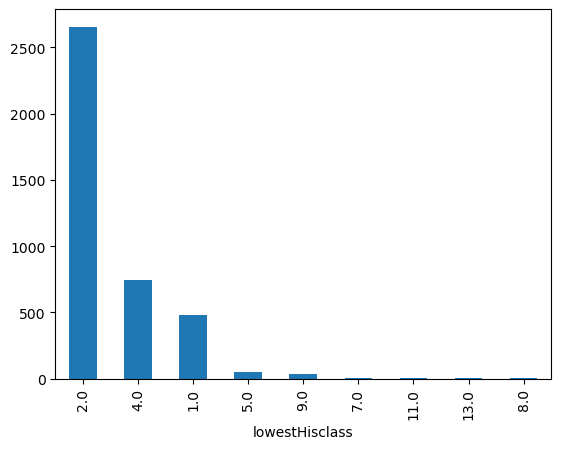

In [29]:
# Generate a bar plot visualising the total number per lowest_class
metadata_final_df['lowestHisclass'].value_counts().plot(kind='bar')
metadata_final_df['lowestHisclass'].value_counts()

leraar        1269
hoogleraar    1112
docent        1112
redacteur      521
journalist     521
vertaler       470
historicus     313
archeoloog     313
jurist         293
advocaat       293
Name: count, dtype: int64

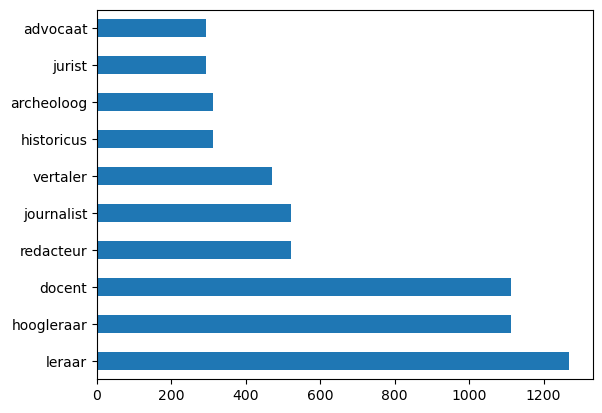

In [30]:
# Reread metadata_occupation.txt into a new df
metadata2_df = metadata_final_df
metadata2_df = metadata2_df.dropna(subset=['occupation'])

# Split occupations and spread across multiple rows
metadata2_df = metadata2_df['occupation'].str.split('/', expand=True).stack()

# Generate a bar plot visualising the total number for the top 10 occupations
metadata2_df.value_counts().head(10).plot(kind='barh')
metadata2_df.value_counts().head(10)